In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
cwd = os.getcwd()

proj_dir = Path(cwd).parent

Let's have a look at Toms solar flux calculator

In [4]:
df = pd.read_csv(
    os.path.join(proj_dir, "database/ts_datasets/", "SolarFluxCheck.csv"),
    sep=";"
    )

df.head()

,time,"SIN(Angle between surface and radiation (θ, Rad))"
0,1-jan,DARK
1,1-jan,DARK
2,1-jan,DARK
3,1-jan,DARK
4,1-jan,DARK


In [5]:
data = []

for i, row in df.iterrows():
    try:
        # print(row["SIN(Angle between surface and radiation (θ, Rad))"])
        data.append(np.float64(row["SIN(Angle between surface and radiation (θ, Rad))"].replace(",", ".")))
    except ValueError:
        data.append(np.nan)

df['data'] = np.array(data)

In [6]:
df.head()

print(len(df))
print(np.sum(np.isnan(df.data.values)))

8761
4379


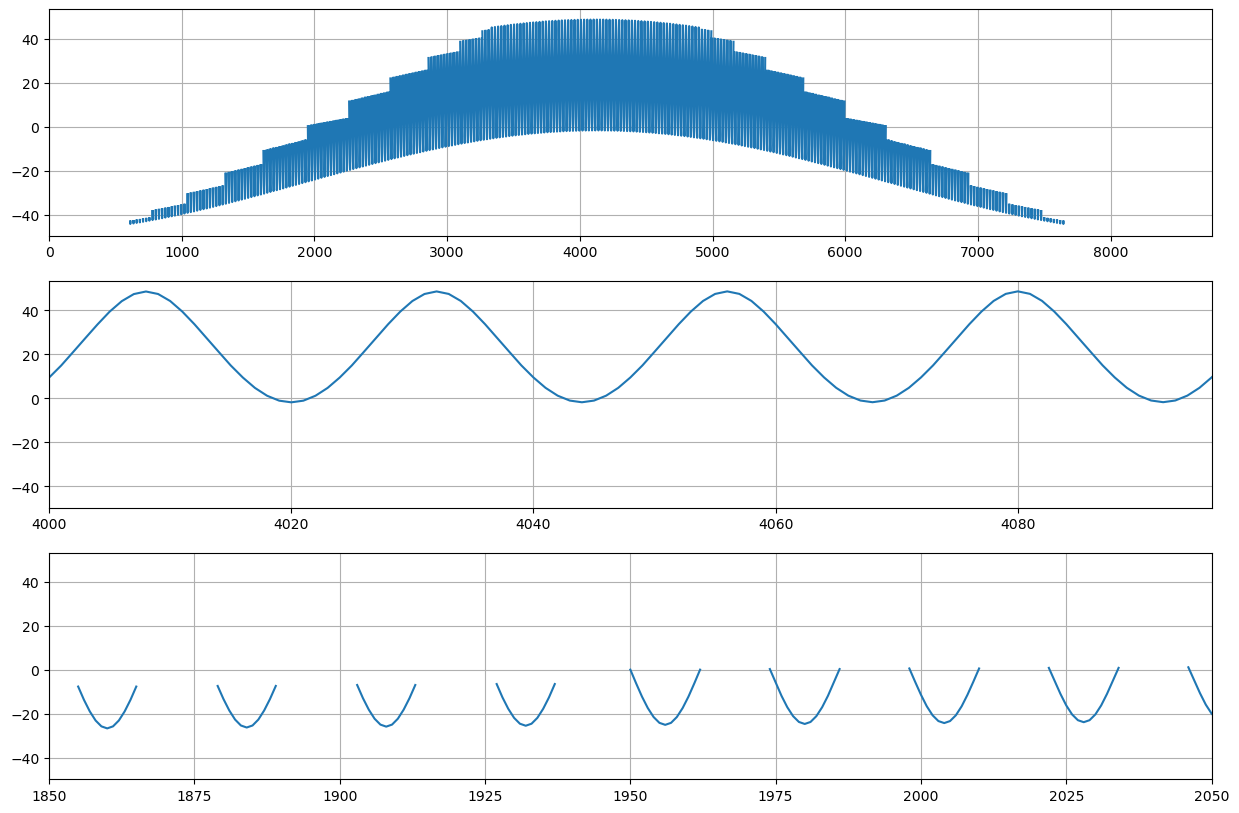

In [7]:
xlim0 = (0, 8761)
xlim1 = (4000, 4096)
xlim2 = (1850, 2050)

index = df.index.values

angle_surface_rad = np.arcsin(df.data.values) / np.pi * 180

fig, ax = plt.subplots(3, 1, figsize=(15,10))

ax[0].plot(index, angle_surface_rad)
ax[1].plot(index, angle_surface_rad)
ax[2].plot(index, angle_surface_rad)

ax[0].set_xlim((xlim0))
ax[1].set_xlim((xlim1))
ax[2].set_xlim((xlim2))

ax[0].grid()
ax[1].grid()
ax[2].grid()

Now my own implementation

In [8]:
latitude = 70.2  # degrees
surface_azimuth_angle = 2
angle = 45

timestamps = pd.date_range('2023-01-01', '2024-01-01', freq='1h', inclusive='left')

In [9]:
# slope angle
beta = angle / 360 * 2 * np.pi

# latitude
phi = latitude / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

# surface azimuth angle to radians
aspect = surface_azimuth_angle / 360 * 2 * np.pi

A = np.arcsin(np.cos(phi) * np.cos(delta) * np.cos(h) + np.sin(phi) * np.sin(delta))

AZ_no_mod = np.arcsin((np.cos(delta) * (np.sin(h)) / np.cos(A)))

AZ_mod = np.copy(AZ_no_mod)

# set dark values to np.nan
dark_mask = np.nonzero(A <= 0)
AZ_mod[dark_mask] = np.NAN

# set values for when sun crosses east-west line
ew_AM_mask = np.nonzero(
    (A > 0) * (np.cos(h) <= np.tan(delta) / np.tan(phi)) * (local_hour_of_day <= 12)
    )
ew_PM_mask = np.nonzero(
    (A > 0) * (np.cos(h) <= np.tan(delta) / np.tan(phi)) * (local_hour_of_day > 12)
    )

AZ_mod[ew_AM_mask] = -np.pi + np.abs(AZ_no_mod[ew_AM_mask])
AZ_mod[ew_PM_mask] = np.pi - AZ_no_mod[ew_PM_mask]

# convert from (clockwise from south) to (clockwise from east)
Z = AZ_mod + 1/2 * np.pi

sin_theta = np.sin(A) * np.cos(beta) - np.cos(A) * np.sin(beta) * np.sin(Z - aspect)
sin_0 = np.sin(A) * np.cos(0) - np.cos(A) * np.sin(0) * np.sin(Z - aspect)

theta = np.arcsin(sin_theta) / np.pi * 180
theta0 = np.arcsin(sin_0) / np.pi * 180

print('delta:\t', delta[2046])
print('phi:\t', phi)
print('h:\t', h[2046])
print('hour:\t', local_hour_of_day[2026])
print('A:\t', A[2046])
print('AZ (no mod):\t', AZ_no_mod[2046])
print('AZ (mod):\t', AZ_mod[2046])


# print(A[2045:2060])
# print(AZ_no_mod[2045:2060])
# print(AZ_mod[2045:2060])

delta:	 0.035183647862453975
phi:	 1.2252211349000193
h:	 -1.5707963267948966
hour:	 10
A:	 0.0331028336467217
AZ (no mod):	 -1.5588739358481951
AZ (mod):	 -1.582718717741598


1950


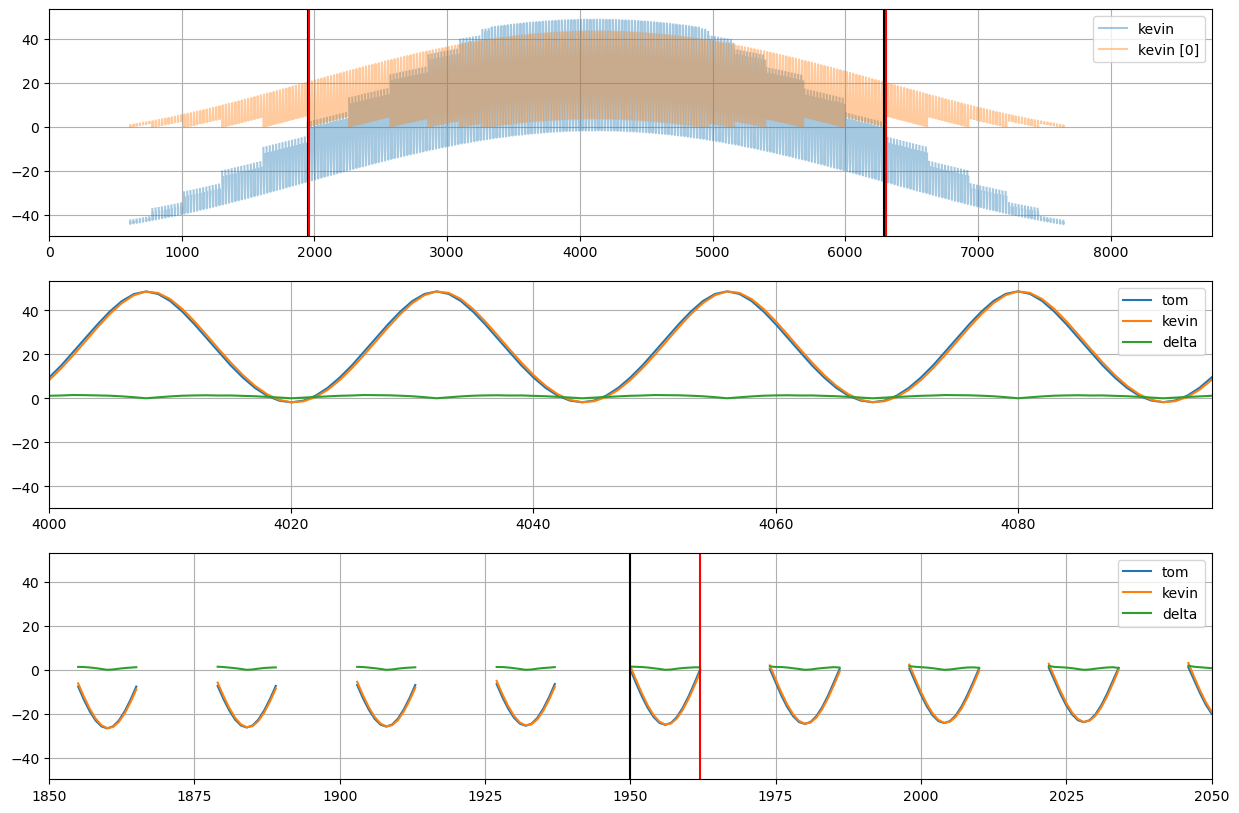

In [10]:
xlim0 = (0, 8761)
xlim1 = (4000, 4096)
xlim2 = (1850, 2050)

index = df.index.values

angle_surface_rad = np.arcsin(df.data.values) / np.pi * 180

fig, ax = plt.subplots(3, 1, figsize=(15,10))

# ax[0].plot(index, angle_surface_rad, label='tom', alpha=0.4)
ax[0].plot(index[:-1], theta, label='kevin',  alpha=0.4)
ax[0].plot(index[:-1], theta0, label='kevin [0]',  alpha=0.4)
# ax[0].plot(index[:-1], np.abs(angle_surface_rad[:-1] - theta), label='delta')

ax[1].plot(index, angle_surface_rad, label='tom')
ax[1].plot(index[:-1], theta, label='kevin')
ax[1].plot(index[:-1], np.abs(angle_surface_rad[:-1] - theta), label='delta')

ax[2].plot(index, angle_surface_rad, label='tom')
ax[2].plot(index[:-1], theta, label='kevin')
ax[2].plot(index[:-1], np.abs(angle_surface_rad[:-1] - theta), label='delta')

ax[0].set_xlim((xlim0))
ax[1].set_xlim((xlim1))
ax[2].set_xlim((xlim2))

ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()

min_AM, max_AM = np.min(ew_AM_mask), np.max(ew_AM_mask)
min_PM, max_PM = np.min(ew_PM_mask), np.max(ew_PM_mask)

print(min_AM)


ax[0].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[0].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[0].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[0].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

ax[1].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[1].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[1].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[1].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

ax[2].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[2].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[2].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[2].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

1950


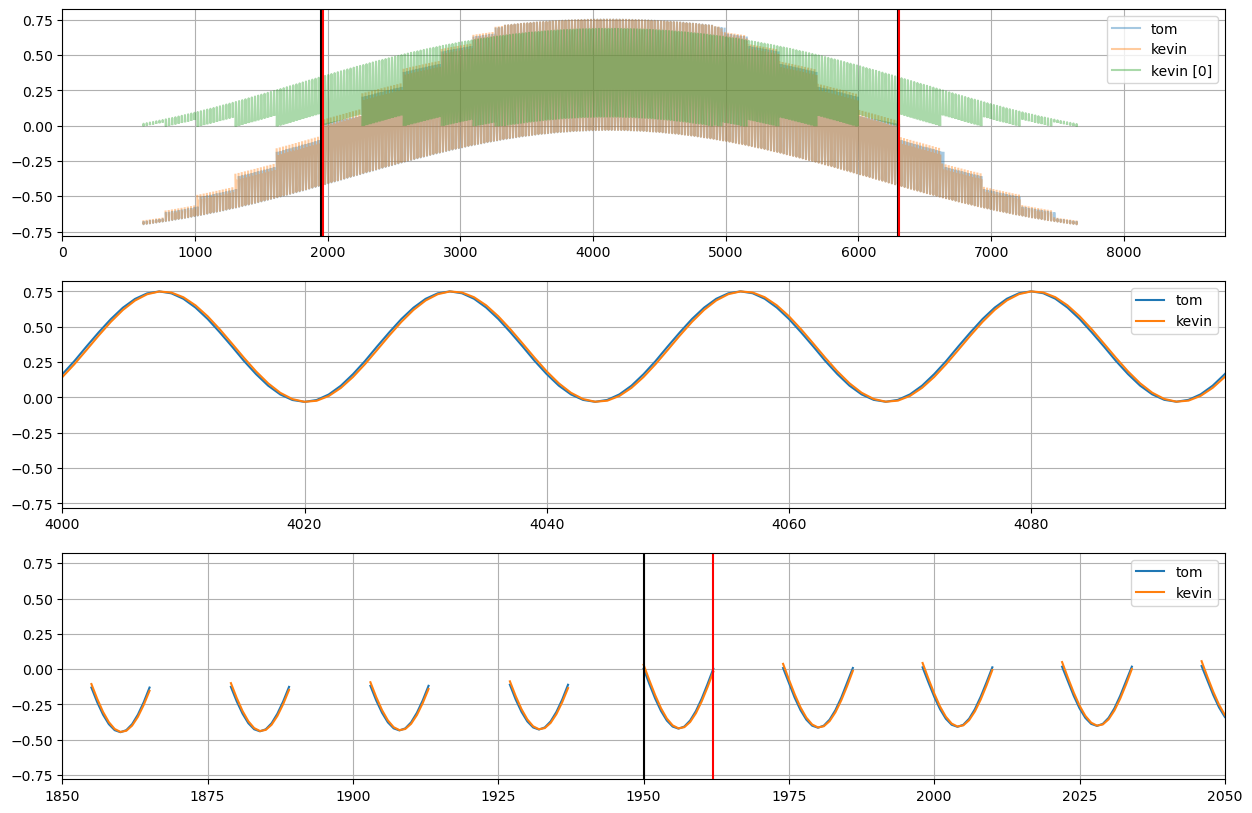

In [11]:
xlim0 = (0, 8761)
xlim1 = (4000, 4096)
xlim2 = (1850, 2050)

index = df.index.values

angle_surface_rad = np.arcsin(df.data.values) / np.pi * 180

fig, ax = plt.subplots(3, 1, figsize=(15,10))

ax[0].plot(index, np.sin(angle_surface_rad / 360 * 2 * np.pi), label='tom', alpha=0.4)
ax[0].plot(index[:-1], sin_theta, label='kevin',  alpha=0.4)
ax[0].plot(index[:-1], sin_0, label='kevin [0]',  alpha=0.4)

ax[1].plot(index, np.sin(angle_surface_rad / 360 * 2 * np.pi), label='tom')
ax[1].plot(index[:-1], sin_theta, label='kevin')

ax[2].plot(index, np.sin(angle_surface_rad / 360 * 2 * np.pi), label='tom')
ax[2].plot(index[:-1], sin_theta, label='kevin')

ax[0].set_xlim((xlim0))
ax[1].set_xlim((xlim1))
ax[2].set_xlim((xlim2))

ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()

min_AM, max_AM = np.min(ew_AM_mask), np.max(ew_AM_mask)
min_PM, max_PM = np.min(ew_PM_mask), np.max(ew_PM_mask)

print(min_AM)

ax[0].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[0].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[0].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[0].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

ax[1].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[1].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[1].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[1].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

ax[2].axvline(x=min_AM, ymin=-40, ymax=60, color='k')
ax[2].axvline(x=max_AM, ymin=-40, ymax=60, color='k')
ax[2].axvline(x=min_PM, ymin=-40, ymax=60, color='r')
ax[2].axvline(x=max_PM, ymin=-40, ymax=60, color='r')

C:\Users\bruij_kn\AppData\Local\Temp\ipykernel_23540\1604199666.py:4: RuntimeWarning: All-NaN slice encountered
  sin_theta_daily_max_2d = np.nanmax(sin_theta_2d, axis=1)
C:\Users\bruij_kn\AppData\Local\Temp\ipykernel_23540\1604199666.py:8: RuntimeWarning: All-NaN slice encountered
  sin_0_daily_max_2d = np.nanmax(sin_0_2d, axis=1)


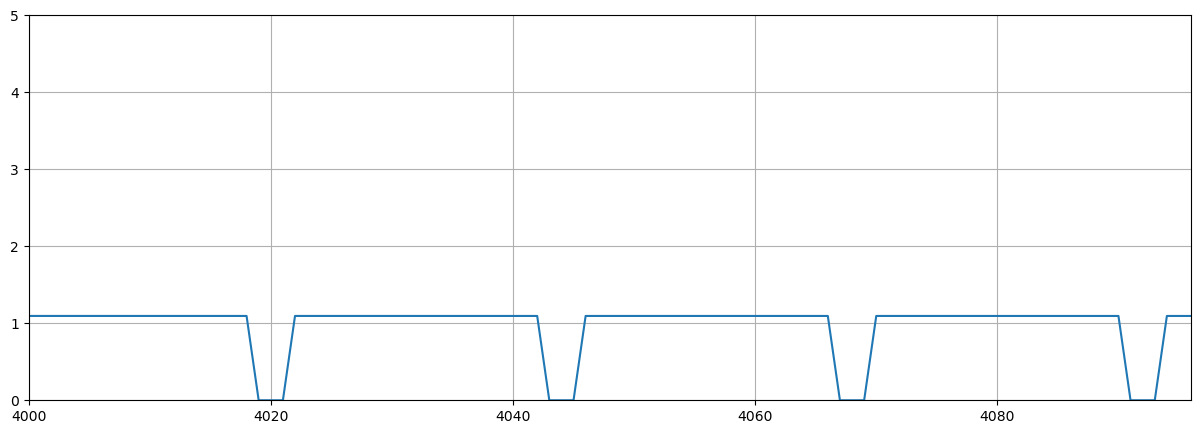

In [12]:
shadow_mask = np.nonzero(theta < 0)

sin_theta_2d = sin_theta.reshape((-1, 24))
sin_theta_daily_max_2d = np.nanmax(sin_theta_2d, axis=1)
sin_theta_daily_max = np.repeat(sin_theta_daily_max_2d.flatten(), 24)

sin_0_2d = sin_0.reshape((-1, 24))
sin_0_daily_max_2d = np.nanmax(sin_0_2d, axis=1)
sin_0_daily_max = np.repeat(sin_0_daily_max_2d.flatten(), 24)

factor = sin_theta_daily_max / sin_0_daily_max

factor[shadow_mask] = 0

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(index[:-1], factor)
# ax.plot(index[:-1], sin_theta_daily_max)
# ax.plot(index[:-1], sin_0_daily_max)
# ax.plot(index[:-1], sin_theta_daily_max/sin_0_daily_max)

ax.set_ylim(0, 5)
ax.set_xlim(4000, 4096)
ax.grid()

In [13]:
print(h[:24])

[-3.14159265 -2.87979327 -2.61799388 -2.35619449 -2.0943951  -1.83259571
 -1.57079633 -1.30899694 -1.04719755 -0.78539816 -0.52359878 -0.26179939
  0.          0.26179939  0.52359878  0.78539816  1.04719755  1.30899694
  1.57079633  1.83259571  2.0943951   2.35619449  2.61799388  2.87979327]


In [14]:
np.max(np.array([-1, 0, 100, np.NAN]))

nan